Now that we have fixed and generated three feature subsets
1. non-lagged + lagged textual features
2. lagged {target,item,shop} + non-lagged basic categories
3. lagged features within shop

and three first level classifiers types for each
* a.  CatBoost
* b. RidgeCV 
* c. Random Forest (sklearn) 

we search for hyperarameters that are used for predicting a month 
based on twelve month history, with one month gap between training and prediction periods.

This is a compromise of the prediction quality on the other hand, and not having the prediction 
quality and optimal hyperparameters vary too much over the training period when generating the first level predictions as input features of second stacking level.

The search for hyperparameters is problematic in whole because the chosen validation scheme is lacking. There may not be
too much that can be done, because the validation data necessarily has different distribution as the actual testing data.
This is because the temporal nature of the prediction problem. The distributions slowly drift during cause of time. Therefore, 
it is good to have the validation period temporally close to the test period. On the other hand, data analysis shows strong seasonal=(yearly) effects. 
Predicting October sales based on previous year simply is a very different problem to predicting December sales, as sales figures seem to peak strongly in December and have special characteristics.

We decide to search for such hyperparameters that maximise the quality of predictions (with
reasonable computational burden) in the hold-out validation data of Oct 2015. This is despite the fact that we have seen in examples that
such optimal model hyperparameters do not result in optimal prediction quality for Dec 2015.
We specifically do not search for such hyperparameters (via a coross-validation scheme) that would maximise the quality of predictions during
the training period, as the value of temporally distant predictions is questionable after because of the distribution shift throughtime.


The parameters are used for
a) creating submissions for ensembling using simple schemes
b) generating level 2 input features for a stacking algorithm



In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
from sklearn.metrics import r2_score
import catboost
import gc
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool

import re
import os

for p in [np, pd, scipy, sklearn, lgb, catboost]:
    print (p.__name__, p.__version__)
    
DATA_FOLDER = 'competitive-data-science-predict-future-sales'
test_spec = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

index_cols=['item_id','shop_id','date_block_num']
date_block_val = 33
date_block_test = 35 # Dec 2015

test2submission_mapping_generated = False

numpy 1.18.1
pandas 0.25.3
scipy 1.4.1
sklearn 0.22.1
lightgbm 2.3.1
catboost 0.22


In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
def write_predictions_by_array(array, filename):
  df=pd.DataFrame(array)
  df.columns=['item_cnt_month']
  df.to_csv(os.path.join(DATA_FOLDER, filename), index_label='ID')

In [4]:
def clipped_rmse(gt, predicted,clip_min=0, clip_max=20):
  target=np.minimum(np.maximum(gt,clip_min), clip_max)
  return np.sqrt((target-predicted)**2).mean()

# Feature set 1: non-lagged and lagged basic categories

In [5]:
# load data

all_data = pd.read_csv(os.path.join(DATA_FOLDER, 'feature_set_basic.csv'))

dates=all_data['date_block_num']

dates_train = (dates>= date_block_val - 13) & (dates<= date_block_val - 2)
dates_trainval = (dates>= date_block_test - 13) & (dates<= date_block_test - 2)
# y_train = all_data.loc[(dates>= date_block_val - 13) & (dates<= date_block_val - 2), 'target']
# y_trainval = all_data.loc[(dates>= date_block_test - 13) & (dates<= date_block_test - 2), 'target']

y_train=all_data.loc[dates_train, 'target']
y_trainval=all_data.loc[dates_trainval, 'target']
y_val = all_data.loc[dates == date_block_val, 'target']
y_test = all_data.loc[dates == date_block_test, 'target']

to_drop_cols = ['target','date_block_num']

X_train = all_data.loc[dates_train].drop(to_drop_cols, axis=1)
X_trainval = all_data.loc[dates_trainval].drop(to_drop_cols, axis=1)
X_val = all_data.loc[dates == date_block_val].drop(to_drop_cols, axis=1)
X_test = all_data.loc[dates == date_block_test].drop(to_drop_cols, axis=1)

shop_item2submissionid={}
for idx, row in test_spec.iterrows():
    shop_item2submissionid[str(row['shop_id'])+'_'+str(row['item_id'])] = row['ID']
    
test_data=all_data.loc[dates == date_block_test, ['shop_id','item_id']]    
    
testidx2submissionidx=np.zeros(test_data.shape[0], dtype=np.int32)
for idx in range(test_data.shape[0]):
    row =test_data.iloc[idx]
    testidx2submissionidx[idx] = shop_item2submissionid[str(row['shop_id'])+'_'+str(row['item_id'])]
    
 
#invert the mapping
submissionidx2testidx=np.zeros(test_data.shape[0], dtype=np.int32)
for i in range(test_data.shape[0]):
    submissionidx2testidx[testidx2submissionidx[i]]=i
    
del test_data
gc.collect()    



0

In [7]:
print(y_train.shape)
print(X_train.shape)

(2768948,)
(2768948, 21)


First tackle ridge regression

In [ ]:
from sklearn import linear_model

#model=linear_model.RidgeCV(alphas=np.logspace(-3,13))
model=linear_model.Ridge(alpha=3e6, fit_intercept=False)
model.fit(X_train.to_numpy(), y_train)
pred_val = np.clip(model.predict(X_val.to_numpy()), 0, 20)
#print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))

model.fit(X_trainval.to_numpy(), y_trainval)
pred_test = np.clip(model.predict(X_test.to_numpy()), 0, 20)
write_predictions_by_array(pred_test[submissionidx2testidx], 'submission-ridge-feature_set_basic.csv')
# LB 1.091266 and 1.088610


In [ ]:
from sklearn import linear_model

#model=linear_model.RidgeCV(alphas=np.logspace(-3,13), normalize=True)
model=linear_model.Ridge(alpha=0.2, normalize=True)
model.fit(X_train.to_numpy(), y_train)
pred_val = np.clip(model.predict(X_val.to_numpy()), 0, 20)
#print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))

model.fit(X_trainval.to_numpy(), y_trainval)
pred_test = np.clip(model.predict(X_test.to_numpy()), 0, 20)
write_predictions_by_array(pred_test[submissionidx2testidx], 'submission-ridge-normalized-feature_set_basic.csv')
# LB 1.082613 and 1.079229.


In [ ]:
model.alpha_

In [ ]:
# then Catboost
from sklearn import model_selection

reg=CatBoostRegressor(task_type='GPU', loss_function='RMSE', iterations=1200, eta=0.03)

grid = {'depth': range(5,17)}
        
        

reg.grid_search(grid, cv=5, X=X_train.to_numpy(), y=y_train, plot=True)

In [9]:
reg=CatBoostRegressor(task_type='GPU', iterations=120, depth=16, eta=0.3,metric_period=20)
eval_dataset= Pool(X_val,y_val)
reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
#print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))

0:	learn: 3.3958183	test: 5.3132972	best: 5.3132972 (0)	total: 377ms	remaining: 44.8s
20:	learn: 2.3590286	test: 4.9282864	best: 4.9282864 (20)	total: 6.93s	remaining: 32.7s
40:	learn: 2.1750684	test: 4.8845876	best: 4.8845876 (40)	total: 13.5s	remaining: 26.1s
60:	learn: 2.0622922	test: 4.8864402	best: 4.8845876 (40)	total: 20.2s	remaining: 19.5s
80:	learn: 1.9640144	test: 4.8881669	best: 4.8845876 (40)	total: 26.9s	remaining: 13s
100:	learn: 1.8846092	test: 4.8874258	best: 4.8845876 (40)	total: 33.6s	remaining: 6.32s
119:	learn: 1.8466087	test: 4.8860043	best: 4.8845876 (40)	total: 40s	remaining: 0us
bestTest = 4.884587648
bestIteration = 40
Shrink model to first 41 iterations.
Clipped RMSE 0.37297401685751475


In [ ]:
# Let's experiment with faster learning rate and less iterations to roughly find sensible hyperparameters

# parameters to tune: depth, bootstrap_type, bagging temprerature (for Bayesian bootstrap), subsample
# grow_policy -> min_data_in_leaf, max_leaves



In [ ]:
res_dict={}
N_RAND=10
for d in range(1,17):
    print('depth: ',d)
    sum = 0
    for r in range(N_RAND):
        reg=CatBoostRegressor(task_type='GPU', iterations=120, depth=d, eta=0.3,metric_period=20, random_seed = r)
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
    res_dict[d] = sum / N_RAND
  
print(res_dict)

# there's about +- 0.010 random fluctuation in scores of individual runs
# maybe simple ensembling already on first level to avoid bad luck?


# {1: 0.41843556427060136, 2: 0.39200723272663457, 3: 0.38961572543553347, 4: 0.39156671290508477, 5: 0.3891002776724449, 6: 0.386308048622023, 7: 0.3857013124069831, 8: 0.38184490124245063, 9: 0.3778682006343534, 10: 0.3755674367385847, 11: 0.37650542801215753, 12: 0.37621294975325814, 13: 0.37367612525383515, 14: 0.3740070625371101, 15: 0.37319345260938475, 16: 0.3703305527864274}
# it seems that maximum available depth of 16 is a reasonable choice



In [ ]:
res_dict={}
N_RAND=10
for s in np.linspace(0.5,1.0,20):
    print('subsample: ',s)
    sum = 0
    for r in range(N_RAND):
        reg=CatBoostRegressor(task_type='GPU', iterations=120, depth=16, eta=0.3,metric_period=20, subsample=s, bootstrap_type='Bernoulli', random_seed = r)
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
    res_dict[s] = sum / N_RAND
  
print(res_dict)

# {0.5: 0.37720847394133683, 0.5263157894736842: 0.37968235475551115, 0.5526315789473684: 0.373719447235152, 0.5789473684210527: 0.3738004089195496, 0.6052631578947368: 0.3801445592900391, 0.631578947368421: 0.3764996905535196, 0.6578947368421053: 0.3756872315081908, 0.6842105263157895: 0.3803532474804272, 0.7105263157894737: 0.3752644353767258, 0.7368421052631579: 0.37537710048459927, 0.763157894736842: 0.37466870958854703, 
# 0.7894736842105263: 0.37254016810717994, 0.8157894736842105: 0.3770991314953297, 0.8421052631578947: 0.3736975968544275, 0.868421052631579: 0.3782591167219179, 0.8947368421052632: 0.3757776519133261, 0.9210526315789473: 0.3753221768209526, 0.9473684210526315: 0.37274794779142245, 0.9736842105263157: 0.3721892562033758, 1.0: 0.3712936972609858}

# Bernoulli Sampling seems to work ok, but does not bring marked improvements
# the value of subsample parameter seems to have little effect if at all


In [ ]:
res_dict={}
N_RAND=10
for s in np.linspace(0.5,1.0,20):
    print('subsample: ',s)
    sum = 0
    for r in range(N_RAND):
        reg=CatBoostRegressor(task_type='GPU', iterations=120, depth=16, eta=0.3,metric_period=20, subsample=s, bootstrap_type='Poisson', random_seed = r)
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
    res_dict[s] = sum / N_RAND
  
print(res_dict)

# roughly similar results as in 'Bernoulli' case
# no need to use this


In [ ]:
res_dict={}
N_RAND=8
for t in np.logspace(-3,3,20):
    print('bagging_temperature: ',t)
    sum = 0
    for r in range(N_RAND):
        reg=CatBoostRegressor(task_type='GPU', iterations=120, depth=16, eta=0.3,metric_period=20, bagging_temperature=t, bootstrap_type='Bayesian', random_seed = r)
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
    res_dict[t] = sum / N_RAND
  
print(res_dict)

# no gains to be found here. The default value seems to work fine. Extremely large values radically worsen the performance


In [ ]:
res_dict={}
N_RAND=8
for regul in np.logspace(-3,3,20):
    print('l2_leaf_reg: ',regul)
    sum = 0
    for r in range(N_RAND):
        reg=CatBoostRegressor(task_type='GPU', iterations=120, depth=16, eta=0.3,metric_period=20, l2_leaf_reg=regul, bootstrap_type='Bayesian', random_seed = r)
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
    res_dict[regul] = sum / N_RAND
  
print(res_dict)

# LEARNING RESULTS SEEM ROBUST ALSO with respect to this parameter'
# only very large values worsen the validation outcome. Defaualt value 3.0 seems ok.


In [ ]:
# now start with large learning rate and gradually decrease it 
# until validation accuracy no longer improves
# use early stopping and sufficient number of iterations


In [20]:
res_dict={}
sum=0
N_RAND=8
lr=0.03
iterations=int(80*(0.5/lr))
for r in range(N_RAND):
        print(lr,iterations)
        reg=CatBoostRegressor(task_type='GPU', iterations=iterations, depth=16, eta=lr,metric_period=20, bootstrap_type='Bayesian', random_seed = r, early_stopping_rounds=int(iterations*0.02+10))
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
res_dict[lr] = sum / N_RAND
  
print(res_dict)


0.03 1333
0:	learn: 3.6997514	test: 5.4410352	best: 5.4410352 (0)	total: 353ms	remaining: 7m 50s
20:	learn: 3.1737498	test: 5.1769064	best: 5.1769064 (20)	total: 6.94s	remaining: 7m 13s
40:	learn: 2.8846992	test: 5.0488605	best: 5.0488605 (40)	total: 13.5s	remaining: 7m 6s
60:	learn: 2.7165338	test: 5.0030804	best: 5.0030804 (60)	total: 20.1s	remaining: 6m 59s
80:	learn: 2.6097085	test: 4.9680828	best: 4.9680828 (80)	total: 26.7s	remaining: 6m 53s
100:	learn: 2.5353303	test: 4.9669451	best: 4.9667497 (95)	total: 33.4s	remaining: 6m 47s
120:	learn: 2.4865230	test: 4.9616093	best: 4.9613135 (118)	total: 40s	remaining: 6m 40s
140:	learn: 2.4493873	test: 4.9562335	best: 4.9561030 (138)	total: 46.6s	remaining: 6m 34s
160:	learn: 2.4165739	test: 4.9521989	best: 4.9521989 (160)	total: 53.2s	remaining: 6m 27s
180:	learn: 2.3905519	test: 4.9397012	best: 4.9396261 (179)	total: 59.8s	remaining: 6m 20s
200:	learn: 2.3707250	test: 4.9349820	best: 4.9348875 (199)	total: 1m 6s	remaining: 6m 14s
220:	

In [ ]:
res_dict={}
sum=0
N_RAND=8
lr=0.01
iterations=int(80*(0.5/lr))
for r in range(N_RAND):
        print(lr,iterations)
        reg=CatBoostRegressor(task_type='GPU', iterations=iterations, depth=16, eta=lr,metric_period=20, bootstrap_type='Bayesian', random_seed = r, early_stopping_rounds=int(iterations*0.02+10))
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
res_dict[lr] = sum / N_RAND
  
print(res_dict)


0.01 4000
0:	learn: 3.7237479	test: 5.4518077	best: 5.4518077 (0)	total: 393ms	remaining: 26m 10s
20:	learn: 3.5089020	test: 5.3283004	best: 5.3283004 (20)	total: 6.91s	remaining: 21m 49s
40:	learn: 3.3334702	test: 5.2247160	best: 5.2247160 (40)	total: 13.4s	remaining: 21m 37s
60:	learn: 3.1922812	test: 5.1568875	best: 5.1568875 (60)	total: 19.9s	remaining: 21m 26s
80:	learn: 3.0750472	test: 5.1081199	best: 5.1081199 (80)	total: 26.5s	remaining: 21m 20s
100:	learn: 2.9772401	test: 5.0686783	best: 5.0686783 (100)	total: 33s	remaining: 21m 13s
120:	learn: 2.8958863	test: 5.0309692	best: 5.0309692 (120)	total: 39.5s	remaining: 21m 6s
140:	learn: 2.8302892	test: 5.0072035	best: 5.0072035 (140)	total: 46s	remaining: 20m 59s
160:	learn: 2.7719179	test: 4.9856563	best: 4.9856563 (160)	total: 52.6s	remaining: 20m 53s
180:	learn: 2.7237737	test: 4.9719135	best: 4.9719135 (180)	total: 59.1s	remaining: 20m 47s
200:	learn: 2.6832598	test: 4.9620254	best: 4.9620254 (200)	total: 1m 5s	remaining: 20m

In [6]:
# it seems that small learning rates are just waste of computational time
# let's try how fast we can set learning to be

res_dict={}
sum=0
N_RAND=8
lr=1
iterations=int(80*(0.5/lr))
for r in range(N_RAND):
        print(lr,iterations)
        reg=CatBoostRegressor(task_type='GPU', iterations=iterations, depth=16, eta=lr,metric_period=20, bootstrap_type='Bayesian', random_seed = r, early_stopping_rounds=int(iterations*0.02+10))
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
res_dict[lr] = sum / N_RAND
  
print(res_dict)


1 40
0:	learn: 2.8447050	test: 5.1468076	best: 5.1468076 (0)	total: 375ms	remaining: 14.6s
20:	learn: 2.0045789	test: 5.0567908	best: 5.0567908 (20)	total: 7.04s	remaining: 6.37s
39:	learn: 1.8508471	test: 5.0515155	best: 5.0471617 (31)	total: 13.5s	remaining: 0us
bestTest = 5.047161731
bestIteration = 31
Shrink model to first 32 iterations.
Clipped RMSE 0.3687039143432808
1 40
0:	learn: 2.8784291	test: 5.1254420	best: 5.1254420 (0)	total: 315ms	remaining: 12.3s
20:	learn: 1.9967958	test: 4.9911814	best: 4.9615997 (12)	total: 6.76s	remaining: 6.12s
bestTest = 4.961599731
bestIteration = 12
Shrink model to first 13 iterations.
Clipped RMSE 0.3872504131141077
1 40
0:	learn: 2.9268201	test: 5.1495053	best: 5.1495053 (0)	total: 322ms	remaining: 12.5s
20:	learn: 1.9901298	test: 4.7498153	best: 4.6505668 (13)	total: 6.92s	remaining: 6.26s
bestTest = 4.650566806
bestIteration = 13
Shrink model to first 14 iterations.
Clipped RMSE 0.40155019584905843
1 40
0:	learn: 2.8629551	test: 5.1529439	be

In [7]:
# lr 1 seems too fast, the quality suffers
res_dict={}
sum=0
N_RAND=8
lr=0.3
iterations=int(80*(0.5/lr))
for r in range(N_RAND):
        print(lr,iterations)
        reg=CatBoostRegressor(task_type='GPU', iterations=iterations, depth=16, eta=lr,metric_period=20, bootstrap_type='Bayesian', random_seed = r, early_stopping_rounds=int(iterations*0.02+10))
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
res_dict[lr] = sum / N_RAND
  
print(res_dict)




0.3 133
0:	learn: 3.3958183	test: 5.3132972	best: 5.3132972 (0)	total: 370ms	remaining: 48.9s
20:	learn: 2.3590286	test: 4.9282864	best: 4.9255041 (15)	total: 6.95s	remaining: 37.1s
40:	learn: 2.1634238	test: 4.8878485	best: 4.8871728 (38)	total: 13.6s	remaining: 30.5s
60:	learn: 2.0433477	test: 4.8812660	best: 4.8801312 (59)	total: 20.3s	remaining: 24s
bestTest = 4.880131166
bestIteration = 59
Shrink model to first 60 iterations.
Clipped RMSE 0.3651273477485746
0.3 133
0:	learn: 3.4023018	test: 5.2973597	best: 5.2973597 (0)	total: 316ms	remaining: 41.7s
20:	learn: 2.3944166	test: 4.9289745	best: 4.9289745 (20)	total: 6.7s	remaining: 35.7s
40:	learn: 2.2069717	test: 4.8799351	best: 4.8799351 (40)	total: 13.1s	remaining: 29.4s
bestTest = 4.879935075
bestIteration = 40
Shrink model to first 41 iterations.
Clipped RMSE 0.38049427003965747
0.3 133
0:	learn: 3.4377938	test: 5.3221058	best: 5.3221058 (0)	total: 324ms	remaining: 42.8s
20:	learn: 2.3805698	test: 4.9356103	best: 4.9276410 (12)	

In [8]:
res_dict={}
sum=0
N_RAND=8
lr=0.1
iterations=int(80*(0.5/lr))
for r in range(N_RAND):
        print(lr,iterations)
        reg=CatBoostRegressor(task_type='GPU', iterations=iterations, depth=16, eta=lr,metric_period=20, bootstrap_type='Bayesian', random_seed = r, early_stopping_rounds=int(iterations*0.02+10))
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
res_dict[lr] = sum / N_RAND
  
print(res_dict)




0.1 400
0:	learn: 3.6172719	test: 5.4047386	best: 5.4047386 (0)	total: 374ms	remaining: 2m 29s
20:	learn: 2.6540645	test: 4.9437433	best: 4.9437433 (20)	total: 6.99s	remaining: 2m 6s
40:	learn: 2.4566330	test: 4.9285316	best: 4.9274344 (39)	total: 13.6s	remaining: 1m 59s
60:	learn: 2.3769466	test: 4.9023807	best: 4.9023807 (60)	total: 20.2s	remaining: 1m 52s
80:	learn: 2.2900738	test: 4.8774175	best: 4.8772620 (78)	total: 26.8s	remaining: 1m 45s
100:	learn: 2.2350115	test: 4.8661489	best: 4.8661489 (100)	total: 33.5s	remaining: 1m 39s
120:	learn: 2.1971579	test: 4.8552609	best: 4.8552609 (120)	total: 39.9s	remaining: 1m 32s
140:	learn: 2.1511917	test: 4.8529575	best: 4.8521713 (130)	total: 46.6s	remaining: 1m 25s
bestTest = 4.852171255
bestIteration = 130
Shrink model to first 131 iterations.
Clipped RMSE 0.37936285210017234
0.1 400
0:	learn: 3.6191227	test: 5.3986108	best: 5.3986108 (0)	total: 318ms	remaining: 2m 6s
20:	learn: 2.6611961	test: 4.9492374	best: 4.9492374 (20)	total: 6.75

In [8]:
# gains seem to have saturated already with lr=0.1 but try lr=0.03 still
res_dict={}
sum=0
N_RAND=8
lr=0.03
iterations=int(80*(0.5/lr))
for r in range(N_RAND):
        print(lr,iterations)
        reg=CatBoostRegressor(task_type='GPU', iterations=iterations, depth=16, eta=lr,metric_period=20, bootstrap_type='Bayesian', random_seed = r, early_stopping_rounds=int(iterations*0.02+10))
        eval_dataset= Pool(X_val,y_val)
        reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
        pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
        print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))
        sum += clipped_rmse(y_val, pred_val)
        
res_dict[lr] = sum / N_RAND
  
print(res_dict)




0.03 1333
0:	learn: 3.6997514	test: 5.4410352	best: 5.4410352 (0)	total: 373ms	remaining: 8m 16s
20:	learn: 3.1737498	test: 5.1769064	best: 5.1769064 (20)	total: 6.9s	remaining: 7m 10s
40:	learn: 2.8846992	test: 5.0488605	best: 5.0488605 (40)	total: 13.4s	remaining: 7m 3s
60:	learn: 2.7165338	test: 5.0030804	best: 5.0030804 (60)	total: 20s	remaining: 6m 56s
80:	learn: 2.6097085	test: 4.9680828	best: 4.9680828 (80)	total: 26.5s	remaining: 6m 50s
100:	learn: 2.5362768	test: 4.9668408	best: 4.9667497 (95)	total: 33.1s	remaining: 6m 43s
120:	learn: 2.4870195	test: 4.9624833	best: 4.9622719 (118)	total: 39.6s	remaining: 6m 36s
140:	learn: 2.4491203	test: 4.9574803	best: 4.9570583 (138)	total: 46.1s	remaining: 6m 30s
160:	learn: 2.4148393	test: 4.9521106	best: 4.9518843 (157)	total: 52.7s	remaining: 6m 23s
180:	learn: 2.3854055	test: 4.9465796	best: 4.9464197 (177)	total: 59.2s	remaining: 6m 16s
200:	learn: 2.3629036	test: 4.9384403	best: 4.9384403 (200)	total: 1m 5s	remaining: 6m 10s
220:	l

Experiment with number of iterations: 

reg=CatBoostRegressor(task_type='GPU', iterations=1200, depth=16, eta=0.03,metric_period=20)
bestTest = 4.89748216
bestIteration = 740
Shrink model to first 741 iterations.
Clipped RMSE 0.3629817122046768



In [8]:
reg=CatBoostRegressor(task_type='GPU', iterations=740, depth=16, eta=0.03,metric_period=20)
reg.fit(X_trainval.to_numpy(), y_trainval)
pred_test = np.clip(reg.predict(X_test.to_numpy()), 0, 20)
write_predictions_by_array(pred_test[submissionidx2testidx], 'submission-catboost-feature_set_basic.csv')
# w/ all previous months 0.989679 and 0.994916
# w/ 12 past month examples LB 0.996330 and 0.993701

0:	learn: 4.1324599	total: 356ms	remaining: 4m 23s
20:	learn: 3.5702479	total: 6.81s	remaining: 3m 53s
40:	learn: 3.1942986	total: 13.1s	remaining: 3m 44s
60:	learn: 2.9399711	total: 19.5s	remaining: 3m 37s
80:	learn: 2.7633477	total: 26s	remaining: 3m 31s
100:	learn: 2.6503653	total: 32.4s	remaining: 3m 24s
120:	learn: 2.5586229	total: 38.7s	remaining: 3m 18s
140:	learn: 2.4876473	total: 45.2s	remaining: 3m 11s
160:	learn: 2.4200432	total: 51.3s	remaining: 3m 4s
180:	learn: 2.3659357	total: 57.7s	remaining: 2m 58s
200:	learn: 2.3251583	total: 1m 4s	remaining: 2m 51s
220:	learn: 2.2851810	total: 1m 10s	remaining: 2m 45s
240:	learn: 2.2526937	total: 1m 16s	remaining: 2m 38s
260:	learn: 2.2252402	total: 1m 23s	remaining: 2m 32s
280:	learn: 2.1876598	total: 1m 29s	remaining: 2m 26s
300:	learn: 2.1530316	total: 1m 35s	remaining: 2m 19s
320:	learn: 2.1291504	total: 1m 42s	remaining: 2m 13s
340:	learn: 2.0988341	total: 1m 48s	remaining: 2m 6s
360:	learn: 2.0775948	total: 1m 54s	remaining: 2m

In [9]:
reg=CatBoostRegressor(task_type='GPU', iterations=150, depth=16, eta=0.1,metric_period=20)
reg.fit(X_trainval.to_numpy(), y_trainval)
pred_test = np.clip(reg.predict(X_test.to_numpy()), 0, 20)
write_predictions_by_array(pred_test[submissionidx2testidx], 'submission-catboost-feature_set_basic-lr0.1.csv')
# w/ 12 past month examples 1.000065 and 1.01164

0:	learn: 4.0391792	total: 390ms	remaining: 58.2s
20:	learn: 2.8746803	total: 6.96s	remaining: 42.7s
40:	learn: 2.5120988	total: 13.5s	remaining: 36s
60:	learn: 2.3010757	total: 20.2s	remaining: 29.5s
80:	learn: 2.1836050	total: 26.8s	remaining: 22.8s
100:	learn: 2.0956925	total: 33.5s	remaining: 16.3s
120:	learn: 2.0083313	total: 40.2s	remaining: 9.63s
140:	learn: 1.9400341	total: 46.8s	remaining: 2.98s
149:	learn: 1.9255151	total: 49.7s	remaining: 0us


In [6]:
reg=CatBoostRegressor(task_type='GPU', iterations=2100, depth=16, eta=0.01,metric_period=20)
reg.fit(X_trainval.to_numpy(), y_trainval)
pred_test = np.clip(reg.predict(X_test.to_numpy()), 0, 20)
write_predictions_by_array(pred_test[submissionidx2testidx], 'submission-catboost-feature_set_basic-lr0.01.csv')
# 0.992844 and 0.991568.

0:	learn: 4.1594903	total: 377ms	remaining: 13m 10s
20:	learn: 3.9370271	total: 6.96s	remaining: 11m 28s
40:	learn: 3.7450632	total: 13.5s	remaining: 11m 18s
60:	learn: 3.5823047	total: 19.9s	remaining: 11m 6s
80:	learn: 3.4345473	total: 26.4s	remaining: 10m 58s
100:	learn: 3.3151162	total: 32.9s	remaining: 10m 50s
120:	learn: 3.2074688	total: 39.3s	remaining: 10m 43s
140:	learn: 3.1184439	total: 45.8s	remaining: 10m 36s
160:	learn: 3.0367506	total: 52.3s	remaining: 10m 29s
180:	learn: 2.9576045	total: 58.8s	remaining: 10m 23s
200:	learn: 2.8959660	total: 1m 5s	remaining: 10m 16s
220:	learn: 2.8395363	total: 1m 11s	remaining: 10m 9s
240:	learn: 2.7896490	total: 1m 18s	remaining: 10m 2s
260:	learn: 2.7460377	total: 1m 24s	remaining: 9m 56s
280:	learn: 2.7018749	total: 1m 31s	remaining: 9m 49s
300:	learn: 2.6613225	total: 1m 37s	remaining: 9m 43s
320:	learn: 2.6261540	total: 1m 43s	remaining: 9m 36s
340:	learn: 2.5911999	total: 1m 50s	remaining: 9m 29s
360:	learn: 2.5657811	total: 1m 56s

In [7]:
#try Random forest classifier

from sklearn.ensemble import RandomForestRegressor

reg=RandomForestRegressor()
reg.fit(X_train.to_numpy(), y_train)
pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))

reg.fit(X_trainval.to_numpy(), y_trainval)
pred_test = np.clip(reg.predict(X_test.to_numpy()), 0, 20)
write_predictions_by_array(pred_test[submissionidx2testidx], 'submission-rf-feature_set_basic.csv')

# LB 1.130909 and 1.145271


Clipped RMSE 0.36903233604193586


In [ ]:
# now look at the hyperparameters of RF regressor

# train a large forest
reg=RandomForestRegressor(n_estimators=1000, n_jobs=-1, verbose=2)
reg.fit(X_train.to_numpy(), y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.9min


building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 25.7min


building tree 159 of 1000


In [ ]:
# Memory exhausted. Seems cumbersome. Let's try to do without

In [13]:
predictions = []
for tree in reg.estimators_:
    predictions.append(tree.predict(X_val.to_numpy()))
    
predictions = np.vstack(predictions)
print(predictions.shape)

cum_mean = np.cumsum(predictions, axis=0)/np.arange(1, predictions.shape[0] + 1)[:, None]
scores = []
for pred in cum_mean:
    scores.append(clipped_rmse(y_val, pred))


(50, 221802)


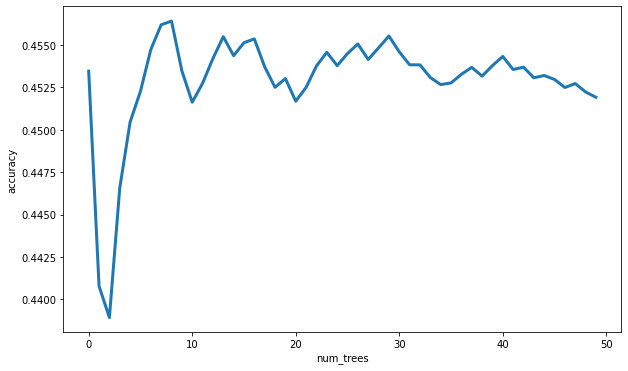

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(scores, linewidth=3)
plt.xlabel('num_trees')
plt.ylabel('accuracy');

X_test

In [10]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':3, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':2
              }
model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb_val = np.clip(model.predict(X_val), 0, 20)
print('Clipped RMSE of lgb predictions is ', clipped_rmse(y_val, pred_lgb_val))
model = lgb.train(lgb_params, lgb.Dataset(X_trainval, label=y_trainval), 100)
pred_lgb_test = np.clip(model.predict(X_test), 0, 20)
write_predictions_by_array(pred_lgb_test[submissionidx2testidx], 'submission-lgb-feature_set_basic.csv')

Clipped RMSE of lgb predictions is  0.374919455274064


Catboost seems to give comparable performance -> use it

In [ ]:
X_test.columns.values

# 2) Feature set 2: text based features

In [5]:
# load data

all_data = pd.read_csv(os.path.join(DATA_FOLDER, 'feature_set_text.csv'))

dates=all_data['date_block_num']

y_train = all_data.loc[(dates>= date_block_val - 9) & (dates<= date_block_val - 2), 'target']
y_trainval = all_data.loc[(dates>= date_block_test - 9) & (dates<= date_block_test - 2), 'target']
y_val = all_data.loc[dates == date_block_val, 'target']
y_test = all_data.loc[dates == date_block_test, 'target']

to_drop_cols = ['target','date_block_num']

X_train = all_data.loc[(dates>= date_block_val - 9) & (dates<= date_block_val - 2)].drop(to_drop_cols, axis=1)
X_trainval = all_data.loc[(dates>= date_block_test - 9) & (dates<= date_block_test - 2)].drop(to_drop_cols, axis=1)
X_val = all_data.loc[dates == date_block_val].drop(to_drop_cols, axis=1)
X_test = all_data.loc[dates == date_block_test].drop(to_drop_cols, axis=1)

shop_item2submissionid={}
for idx, row in test_spec.iterrows():
    shop_item2submissionid[str(row['shop_id'])+'_'+str(row['item_id'])] = row['ID']
    
test_data=all_data.loc[dates == date_block_test, ['shop_id','item_id']]    
    
testidx2submissionidx=np.zeros(test_data.shape[0], dtype=np.int32)
for idx in range(test_data.shape[0]):
    row =test_data.iloc[idx]
    testidx2submissionidx[idx] = shop_item2submissionid[str(row['shop_id'])+'_'+str(row['item_id'])]
    
 
#invert the mapping
submissionidx2testidx=np.zeros(test_data.shape[0], dtype=np.int32)
for i in range(test_data.shape[0]):
    submissionidx2testidx[testidx2submissionidx[i]]=i
    
del test_data
gc.collect()    



0

In [ ]:
from sklearn import linear_model

#model=linear_model.RidgeCV(alphas=np.logspace(-3,13), fit_intercept=True, normalize=True)
model=linear_model.Ridge(alpha=0.04, fit_intercept=True, normalize=True)
model.fit(X_train.to_numpy(), y_train)
pred_val = np.clip(model.predict(X_val.to_numpy()), 0, 20)
#print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))

model.fit(X_trainval.to_numpy(), y_trainval)
pred_test = np.clip(model.predict(X_test.to_numpy()), 0, 20)
write_predictions_by_array(pred_test[submissionidx2testidx], 'submission-ridge-feature_set_text.csv')
# LB 1.203418 and 1.189612


In [ ]:
model.alpha_

In [ ]:
lr=0.01
reg=CatBoostRegressor(task_type='GPU', iterations=2100, depth=16, eta=lr,metric_period=20)
#eval_dataset= Pool(X_val,y_val)
#reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
reg.fit(X_train.to_numpy(), y_train)


In [ ]:
lr=0.01
reg=CatBoostRegressor(task_type='GPU', iterations=2100, depth=16, eta=lr,metric_period=20,early_stopping_rounds=50)
#eval_dataset= Pool(X_val,y_val)
#reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
reg.fit(X_train.to_numpy(), y_train, eval_set=eval_dataset)
pred_val = np.clip(reg.predict(X_val.to_numpy()), 0, 20)
    #print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))

In [ ]:
reg=CatBoostRegressor(task_type='GPU', iterations=2100, depth=16, eta=0.01,metric_period=20)
reg.fit(X_trainval.to_numpy(), y_trainval)
pred_test = np.clip(reg.predict(X_test.to_numpy()), 0, 20)
write_predictions_by_array(pred_test[submissionidx2testidx], 'submission-catboost-feature_set_text-lr0.01.csv')

# Feature set 3: lags within shop

In [ ]:
# load data

all_data = pd.read_csv(os.path.join(DATA_FOLDER, 'feature_set_within.csv'))

dates=all_data['date_block_num']

y_train = all_data.loc[(dates>= date_block_val - 9) & (dates<= date_block_val - 2), 'target']
y_trainval = all_data.loc[(dates>= date_block_test - 9) & (dates<= date_block_test - 2), 'target']
y_val = all_data.loc[dates == date_block_val, 'target']
y_test = all_data.loc[dates == date_block_test, 'target']

to_drop_cols = ['target','date_block_num']

X_train = all_data.loc[(dates>= date_block_val - 9) & (dates<= date_block_val - 2)].drop(to_drop_cols, axis=1)
X_trainval = all_data.loc[(dates>= date_block_test - 9) & (dates<= date_block_test - 2)].drop(to_drop_cols, axis=1)
X_val = all_data.loc[dates == date_block_val].drop(to_drop_cols, axis=1)
X_test = all_data.loc[dates == date_block_test].drop(to_drop_cols, axis=1)

shop_item2submissionid={}
for idx, row in test_spec.iterrows():
    shop_item2submissionid[str(row['shop_id'])+'_'+str(row['item_id'])] = row['ID']
    
test_data=all_data.loc[dates == date_block_test, ['shop_id','item_id']]    
    
testidx2submissionidx=np.zeros(test_data.shape[0], dtype=np.int32)
for idx in range(test_data.shape[0]):
    row =test_data.iloc[idx]
    testidx2submissionidx[idx] = shop_item2submissionid[str(row['shop_id'])+'_'+str(row['item_id'])]
    
 
#invert the mapping
submissionidx2testidx=np.zeros(test_data.shape[0], dtype=np.int32)
for i in range(test_data.shape[0]):
    submissionidx2testidx[testidx2submissionidx[i]]=i
    
del test_data
gc.collect()    



In [ ]:
from sklearn import linear_model

#model=linear_model.RidgeCV(alphas=np.logspace(-3,13), fit_intercept=False)
model=linear_model.Ridge(alpha=3e7, fit_intercept=False)
model.fit(X_train.to_numpy(), y_train)
pred_val = np.clip(model.predict(X_val.to_numpy()), 0, 20)
#print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb_val))
print('Clipped RMSE {}'.format(clipped_rmse(y_val, pred_val)))

model.fit(X_trainval.to_numpy(), y_trainval)
pred_test = np.clip(model.predict(X_test.to_numpy()), 0, 20)
write_predictions_by_array(pred_test[submissionidx2testidx], 'submission-ridge-feature_set_within.csv')
# LB 1.215079 and 1.202396


In [ ]:
model.alpha_